In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
print(torch.__version__)

from helpers import load_training_config, get_all_frames_labels, vis
from attention import CustomAttention
from simplify_model_test import make_tristans

# import os
# import sys
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

# from ToMe.tome import apply_merge, bipartite_soft_matching

# os.chdir('../aot-benchmark')

from multihead_attn import MultiheadAttention

%load_ext autoreload
%autoreload 2

2.0.1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
device = 'mps'
d_model = 256
batch_size = 4

seq_len = 900

m_attn = MultiheadAttention(d_model).to(device)
cust_attn = CustomAttention(d_model).to(device)

Change


In [15]:
q = torch.rand([batch_size, seq_len, d_model]).to(device)
q.shape

torch.Size([4, 900, 256])

In [16]:
q = q.permute(1, 0, 2)

In [17]:
# time test
import time

t0 = time.time()
m_attn(q, q, q)
tf = time.time()
print(tf - t0)

t0 = time.time()
cust_attn(q, q, q)
tf = time.time()
print(tf - t0)

0.005105018615722656
Simplified Attention
torch.Size([4, 8, 900, 900]) torch.Size([900, 4, 256])
torch.Size([900, 4, 256])
0.003019094467163086


In [18]:
from fvcore.nn import flop_count, FlopCountAnalysis, flop_count_str

flops = FlopCountAnalysis(m_attn, (q, q, q))

print(flop_count_str(flops))
flops.total()

MultiheadAttention(
  #params: 0.26M, #flops: 2.6G
  (linear_Q): Linear(
    in_features=256, out_features=256, bias=True
    #params: 65.79K, #flops: 0.24G
  )
  (linear_K): Linear(
    in_features=256, out_features=256, bias=True
    #params: 65.79K, #flops: 0.24G
  )
  (linear_V): Linear(
    in_features=256, out_features=256, bias=True
    #params: 65.79K, #flops: 0.24G
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (projection): Linear(
    in_features=256, out_features=256, bias=True
    #params: 65.79K, #flops: 0.24G
  )
)


2602598400

In [19]:
flops = FlopCountAnalysis(cust_attn, (q, q, q))

print(flop_count_str(flops))
flops.total()

Simplified Attention
torch.Size([4, 8, 900, 900]) torch.Size([900, 4, 256])
torch.Size([900, 4, 256])
CustomAttention(
  #params: 0.2M, #flops: 2.37G
  (linear_Q): Linear(
    in_features=256, out_features=256, bias=True
    #params: 65.79K, #flops: 0.24G
  )
  (linear_K): Linear(
    in_features=256, out_features=256, bias=True
    #params: 65.79K, #flops: 0.24G
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (projection): Linear(
    in_features=256, out_features=256, bias=True
    #params: 65.79K, #flops: 0.24G
  )
)


2366668800

In [37]:
# add in Gaussian noise
with torch.no_grad():
    for param in cust_attn.parameters():
        param.add_(torch.randn(param.size()).to(device) * 0.1)

In [19]:
merge, unmerge = bipartite_soft_matching(q, q.shape[1]//2)

q = apply_merge(q, merge)
print(q.shape)
q = q.permute(1, 0, 2)
q.shape

torch.Size([4, 450, 256])


torch.Size([450, 4, 256])

In [20]:
out, attn = m_attn(q, q, q) # outputs and dropouts

torch.Size([450, 4, 256]) torch.Size([450, 4, 256]) torch.Size([450, 4, 256])
torch.Size([450, 4, 256])


In [21]:
out = out.permute(1, 0, 2)

In [23]:
out = unmerge(out)

In [24]:
print(out.shape)

torch.Size([4, 900, 256])


In [10]:
from networks.layers.transformer import LongShortTermTransformer

lstt = LongShortTermTransformer()

long_term_memory, short_term_memory = None, None

out2, memories = lstt(q, long_term_memory, short_term_memory)

block_version
v1
LSTT: torch.Size([57, 4, 256])
torch.Size([57, 4, 256]) torch.Size([57, 4, 256]) torch.Size([57, 4, 256])
torch.Size([57, 4, 256])
In networks/LSTTblock forward, curr torch.Size([57, 4, 256]) torch.Size([57, 4, 256]) torch.Size([57, 4, 256])


TypeError: cannot unpack non-iterable NoneType object

In [63]:
## Loading model from config
import importlib
from models import AOT

stage = 'pre'
exp_name = "tristan_test"
model_name = "aott"
engine_config = importlib.import_module('configs.' + stage)
cfg = engine_config.EngineConfig(exp_name, model_name)

cfg.DIST_START_GPU = 0  # default value
cfg.TRAIN_GPUS = 1
cfg.DATASETS = 'AOT'
cfg.DIR_AOT = '/gv1/projects/AI_Surrogate/dev/tristan/aot-benchmark/datasets/AOT'
cfg.PRETRAIN_MODEL = "pretrain_model/mobilenet_v2-b0353104.pth"
cfg.DIST_ENABLE = False
cfg.DATA_WORKERS = 2

model = AOT(cfg).to(device)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~
./result/tristan_test_AOTT/PRE/ckpt
HERE
block_version
v1
PositionEmbeddingSine
_init_weight
Starting encoder_projector initialization...
Finished encoder_projector initialization.
Starting patch_wise_id_bank initialization...
Finished patch_wise_id_bank initialization.
Passed


In [64]:
from dataloaders.train_datasets import AOT_Train
from torch.utils.data import DataLoader
import dataloaders.video_transforms as tr
from torchvision import transforms

cfg.enable_prev_frame = True
train_sampler = None

composed_transforms = transforms.Compose([
                tr.RandomScale(cfg.DATA_MIN_SCALE_FACTOR,
                               cfg.DATA_MAX_SCALE_FACTOR,
                               cfg.DATA_SHORT_EDGE_LEN),
                tr.BalancedRandomCrop(cfg.DATA_RANDOMCROP,
                                      max_obj_num=cfg.MODEL_MAX_OBJ_NUM),
                tr.RandomHorizontalFlip(cfg.DATA_RANDOMFLIP),
                tr.Resize(cfg.DATA_RANDOMCROP, use_padding=True),
                tr.ToTensor()])

train_dataset = AOT_Train(
                root=cfg.DIR_AOT,
                transform=composed_transforms,
                seq_len=cfg.DATA_SEQ_LEN,
                rand_gap=cfg.DATA_RANDOM_GAP_AOT,
                rand_reverse=cfg.DATA_RANDOM_REVERSE_SEQ,
                merge_prob=cfg.DATA_DYNAMIC_MERGE_PROB,
                enable_prev_frame=cfg.enable_prev_frame,
                max_obj_n=cfg.MODEL_MAX_OBJ_NUM)

train_loader = DataLoader(train_dataset,
               batch_size=int(cfg.TRAIN_BATCH_SIZE /
                              cfg.TRAIN_GPUS),
               shuffle=False if cfg.DIST_ENABLE else True,
               num_workers=cfg.DATA_WORKERS,
               pin_memory=True,
               sampler=train_sampler,
               drop_last=True,
               prefetch_factor=4)

*********************************************************************************************************************************
Video Num: 23 X 1


In [65]:
for frame_idx, sample in enumerate(train_loader):
    all_frames, all_labels, bs, obj_nums = get_all_frames_labels(sample, 0)
    break

In [31]:
all_frames.shape

torch.Size([96, 3, 465, 465])

In [42]:
all_labels.shape

torch.Size([96, 1, 465, 465])

In [44]:
obj_nums

[1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2]

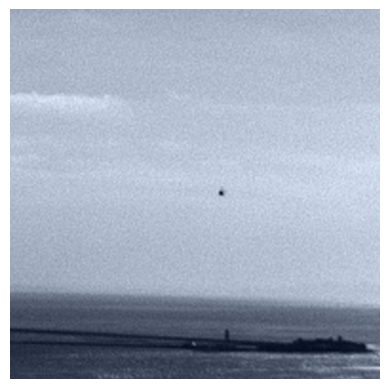

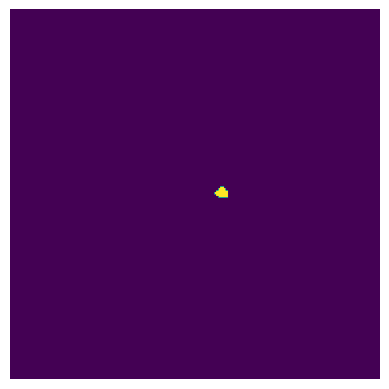

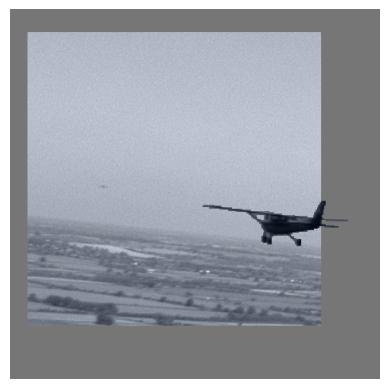

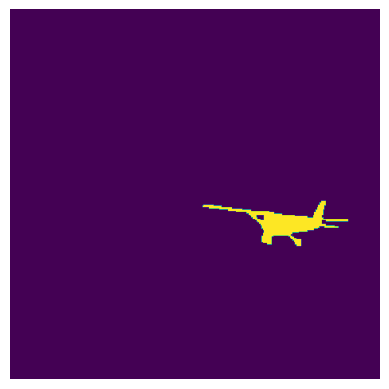

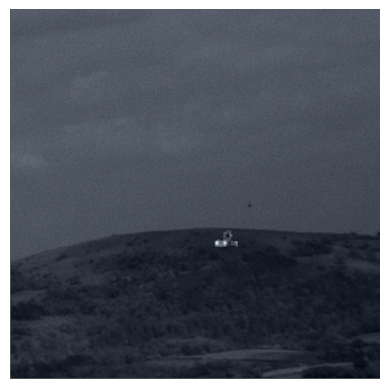

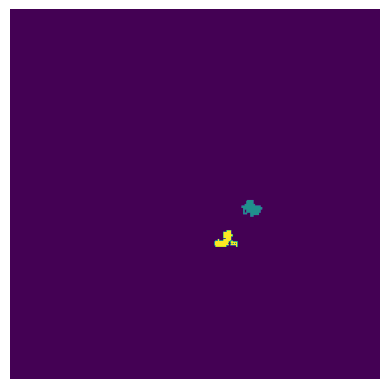

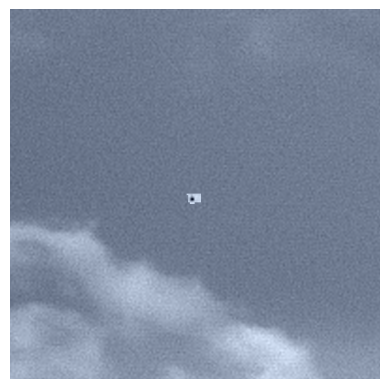

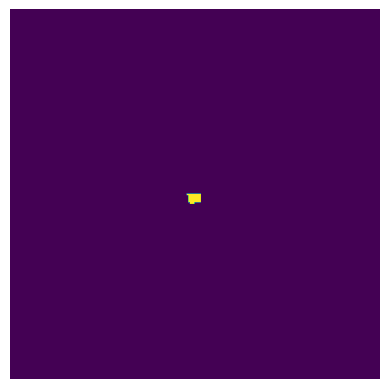

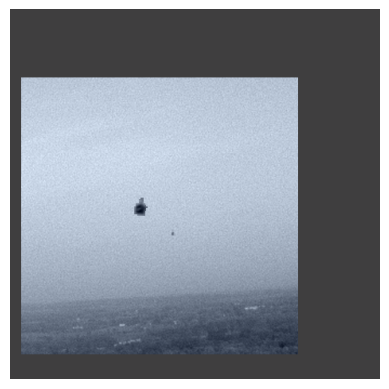

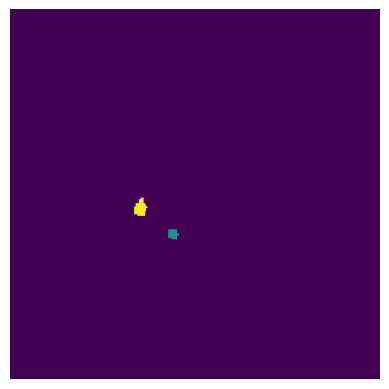

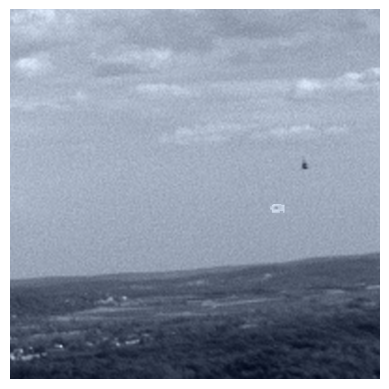

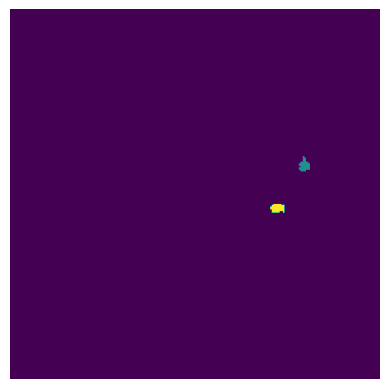

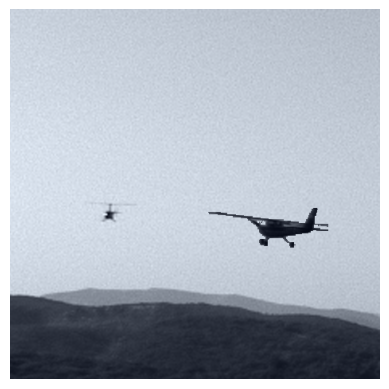

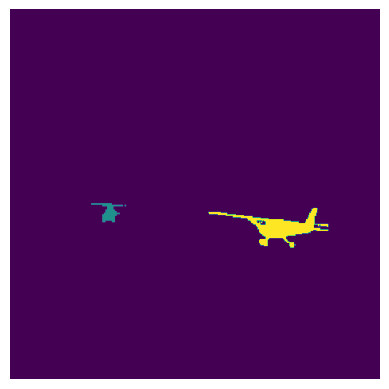

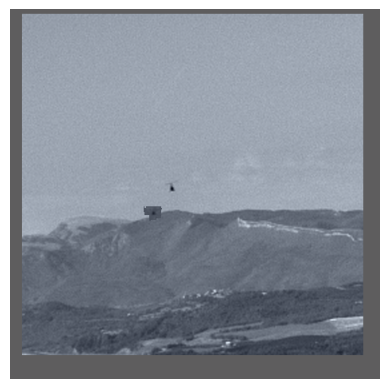

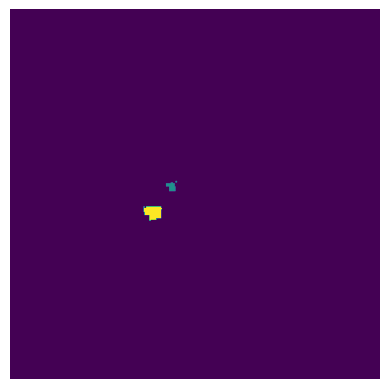

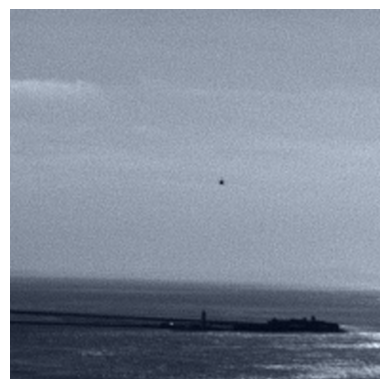

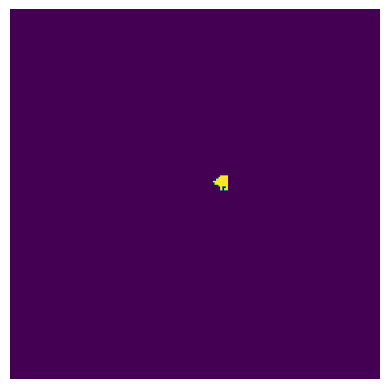

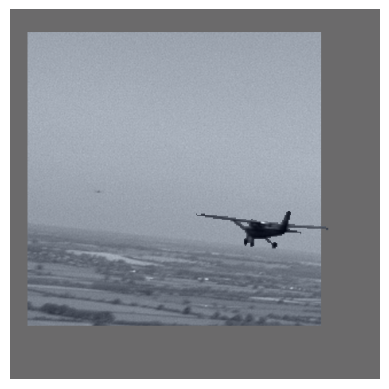

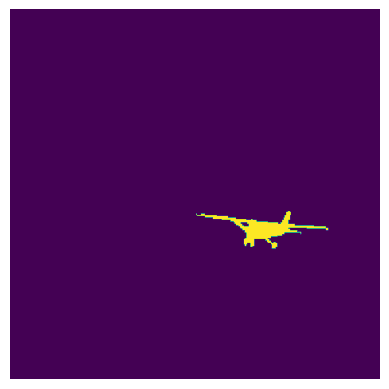

In [32]:
for i in range(0, 96, 10):
    vis(all_frames[i].cpu())
    vis(all_labels[i].cpu())

In [70]:
from engines.aot_engine import AOTEngine

engine = AOTEngine(model).to(device)

# the way they created the model is weird bc they pass in batch_size and fvcore doesn't want int inputs
# flops = FlopCountAnalysis(engine, (all_frames, all_labels, bs))
# print(flops.total())
# print(flop_count_str(flops))

# engine(all_frames, all_labels, bs, obj_nums)

In [71]:
engine = make_tristans(engine)

Called
Called


In [80]:
def multiply_by_ychunks(x, y, chunks=1):
    if chunks <= 1:
        return x @ y
    else:
        return torch.cat([x @ _y for _y in y.chunk(chunks, dim=-1)], dim=-1)
    
def multiply_by_xchunks(x, y, chunks=1):
    if chunks <= 1:
        return x @ y
    else:
        return torch.cat([_x @ y for _x in x.chunk(chunks, dim=-2)], dim=-2)


def simplify_attention(block_class):
    class SimplifiedAttention(block_class):
        # no need to chagne any of the variables, already initialized in parent

        def forward(self, Q, K, V):
            print("Simplified Attention")
            bs = Q.size(1)
            num_head = self.num_head
            hidden_dim = self.hidden_dim

            # Linear projections for Q and K
            if hasattr(self, 'linear_Q'):
                Q = self.linear_Q(Q)
                K = self.linear_K(K)

            # No linear transformation for V, use MLP instead
            V_mlp = self.mlp_V(V)

            # Scale
            Q = Q / self.T

            if not self.training and self.max_mem_len_ratio > 0:
                mem_len_ratio = float(K.size(0)) / Q.size(0)
                if mem_len_ratio > self.max_mem_len_ratio:
                    scaling_ratio = math.log(mem_len_ratio) / math.log(self.max_mem_len_ratio)
                    Q = Q * scaling_ratio

            # Multi-head for Q and K
            Q = Q.view(-1, bs, num_head, self.d_att).permute(1, 2, 0, 3)
            K = K.view(-1, bs, num_head, self.d_att).permute(1, 2, 3, 0)
            V = V.view(-1, bs, num_head, hidden_dim).permute(1, 2, 0, 3)

            # Attention computation
            QK = multiply_by_ychunks(Q, K, self.qk_chunks)
            if self.use_dis:
                QK = 2 * QK - K.pow(2).sum(dim=-2, keepdim=True)
            self.top_k = False
            attn = torch.softmax(QK, dim=-1) if not self.top_k else self.top_k_softmax(QK)
            attn = self.dropout(attn)
            attn_output = multiply_by_xchunks(attn, V, self.qk_chunks).permute(2, 0, 1, 3).reshape(-1, bs, self.d_model)

            # Concatenate attention output and MLP output
            combined_output = torch.cat([attn_output, V_mlp], dim=-1)

            # Final projection
            return self.projection(combined_output), attn

        def top_k_softmax(self, QK):
            top_QK, indices = torch.topk(QK, k=self.top_k, dim=-1)
            top_attn = torch.softmax(top_QK, dim=-1)
            return torch.zeros_like(QK).scatter_(-1, indices, top_attn)

        def _init_weight(self):
            for p in self.parameters():
                if p.dim() > 1:
                    nn.init.xavier_uniform_(p)
                    
    return SimplifiedAttention

In [74]:
def make_tristans(model):
    for module in engine.modules():
        if "MultiheadAttention" == module.__class__.__name__:
            print("Called")
            module.__class__ = simplify_attention(module.__class__)
            module.__class__.__name__ = "TristanAttention"
    return model

In [75]:
for module in engine.modules():
    if "Attention" in module.__class__.__name__:
        print(module)

MultiheadAttention(
  (dropout): Dropout(p=0.0, inplace=False)
  (projection): Linear(in_features=256, out_features=256, bias=True)
)
MultiheadLocalAttentionV2(
  (relative_emb_k): Conv2d(256, 1800, kernel_size=(1, 1), stride=(1, 1), groups=8)
  (correlation_sampler): SpatialCorrelationSampler()
  (projection): Linear(in_features=256, out_features=256, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
MultiheadAttention(
  (linear_Q): Linear(in_features=256, out_features=256, bias=True)
  (linear_K): Linear(in_features=256, out_features=256, bias=True)
  (linear_V): Linear(in_features=256, out_features=256, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (projection): Linear(in_features=256, out_features=256, bias=True)
)


In [76]:
model = make_tristans(engine)
for module in model.modules():
    if "Tristan" in module.__class__.__name__:
        print(module)

Called
Called
TristanAttention(
  (dropout): Dropout(p=0.0, inplace=False)
  (projection): Linear(in_features=256, out_features=256, bias=True)
)
TristanAttention(
  (linear_Q): Linear(in_features=256, out_features=256, bias=True)
  (linear_K): Linear(in_features=256, out_features=256, bias=True)
  (linear_V): Linear(in_features=256, out_features=256, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (projection): Linear(in_features=256, out_features=256, bias=True)
)


In [41]:
engine(all_frames, all_labels, bs, obj_nums)

In engine forward pass: torch.Size([96, 3, 465, 465])
In aot LSTT_forward: 1 256 30 30
LSTT: torch.Size([900, 1, 256])
torch.Size([900, 1, 256]) torch.Size([900, 1, 256]) torch.Size([900, 1, 256])
torch.Size([900, 1, 256])
In networks/LSTTblock forward, curr torch.Size([900, 1, 256]) torch.Size([900, 1, 256]) torch.Size([900, 1, 256])
Back to 2d: torch.Size([1, 256, 30, 30])
torch.Size([900, 1, 256]) torch.Size([900, 1, 256]) torch.Size([900, 1, 256])
torch.Size([900, 1, 256])
torch.Size([1, 11, 117, 117])


IndexError: index 1 is out of bounds for dimension 0 with size 1